# Cal-CRAI Index: Society & Economy Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'society_economy_'  # will be used for naming newly created columns
csv_file_prefix = 'society' # for society & economy domain specifically, all files in this domain are named just society

input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(csv_file_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within societydomain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_society_economy_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['poverty_percent_2019',
  'percent_population_without_health_insurance',
  'linguistic_isolation_percent_2019',
  'avg_hpsscore_primary_care_metric',
  'real_percent_total_pop_over_65',
  'percent_population_cognitive_disabilities',
  'Percent of households without air conditioning',
  'asthma_related_ed_visits_per_10000_people_2019',
  'percent_population_ambulatory_disabilities',
  'percent_children_household_financial_assistance',
  'education_percent_2019',
  'avg_hpsscore_mental_shortage_metric',
  'percent_total_pop_under_5',
  'housing_burden_percent_2019',
  'low_birth_weight_percent_2019',
  'sum_imp_water_bodies',
  'unemployment_percent_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'hachman_index',
  'percent_1miurban_10mirural',
  'Percent of population employed and aged > 16 working outdoors',
  'est_gini_index',
  'Number of Violent Crimes per 10,000 Population',
  'avg_percent_population_homeless',
  'percent_total_pop_ameri

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_society_df = pd.read_csv(merged_output_file)
processed_society_df

,GEOID,health and personal care stores per 10000 people,poverty_percent_2019,hospitals per 10000 people,percent_population_without_health_insurance,linguistic_isolation_percent_2019,avg_hpsscore_primary_care_metric,real_percent_total_pop_over_65,percent_population_cognitive_disabilities,Percent of households without air conditioning,...,hachman_index,percent_1miurban_10mirural,Percent of population employed and aged > 16 working outdoors,est_gini_index,specialty trade contractors per 10000 people,personal and household goods repair and maintenance per 10000 people,"Number of Violent Crimes per 10,000 Population",avg_percent_population_homeless,blood and organ banks per 10000 people,percent_total_pop_american_indian_alaska_native
0,6085504321,2.201550,17.500000,0.083471,3.843311,21.100000,NaN,16.555802,5.210552,35.430875,...,0.788695,27.547393,2.022881,0.4197,11.837246,0.511261,31.703849,0.691595,NaN,0.3
1,6085504410,2.201550,23.100000,0.083471,5.237633,21.100000,NaN,16.197866,3.507880,35.430875,...,0.788695,27.547393,1.144842,0.4309,11.837246,0.511261,31.703849,0.691595,NaN,1.3
2,6085507003,2.201550,17.793413,0.083471,0.260247,11.064134,NaN,26.545218,1.706572,35.430875,...,0.788695,27.547393,4.619098,0.5357,11.837246,0.511261,31.703849,0.691595,NaN,0.0
3,6085507004,2.201550,17.793413,0.083471,0.305655,11.064134,NaN,21.599592,2.310994,35.430875,...,0.788695,27.547393,4.619098,0.4793,11.837246,0.511261,31.703849,0.691595,NaN,0.0
4,6085502204,2.201550,17.793413,0.083471,4.441703,11.064134,NaN,10.579889,9.356358,35.430875,...,0.788695,27.547393,4.619098,0.4010,11.837246,0.511261,31.703849,0.691595,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,3.561950,28.300000,0.119676,7.751343,10.200000,NaN,10.744436,4.544180,28.057946,...,0.934257,25.604689,4.455156,0.3590,14.890274,0.834586,25.871294,0.465096,0.050390,0.4
9125,6059001304,3.561950,46.900000,0.119676,19.607293,15.800000,NaN,18.513324,4.226241,28.057946,...,0.934257,25.604689,8.676318,0.3582,14.890274,0.834586,25.871294,0.465096,0.050390,3.9
9126,6059001401,3.561950,37.600000,0.119676,11.480235,13.300000,NaN,16.000841,6.016556,28.057946,...,0.934257,25.604689,6.810978,0.4594,14.890274,0.834586,25.871294,0.465096,0.050390,2.2
9127,6013367200,1.840626,37.100000,0.197824,6.440620,10.500000,NaN,8.843074,3.351287,30.390365,...,0.919995,36.159475,9.026887,0.4130,13.125211,0.498861,42.765917,0.603696,NaN,0.1


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_society_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_society_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]

In [8]:
min_max_standardized_society_economy_metrics_df.head()

,GEOID,health and personal care stores per 10000 people_min_max_standardized,poverty_percent_2019_min_max_standardized,hospitals per 10000 people_min_max_standardized,percent_population_without_health_insurance_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,avg_hpsscore_primary_care_metric_min_max_standardized,real_percent_total_pop_over_65_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,Percent of households without air conditioning_min_max_standardized,...,hachman_index_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,est_gini_index_min_max_standardized,specialty trade contractors per 10000 people_min_max_standardized,personal and household goods repair and maintenance per 10000 people_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",avg_percent_population_homeless_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized
0,6085504321,0.450004,0.182119,0.0,0.067258,0.211000,NaN,0.165558,0.000883,0.354309,...,0.782753,0.275474,0.026972,0.499360,0.200423,0.251418,0.160749,0.09784,NaN,0.004098
1,6085504410,0.450004,0.243929,0.0,0.091659,0.211000,NaN,0.161979,0.000595,0.354309,...,0.782753,0.275474,0.015265,0.515294,0.200423,0.251418,0.160749,0.09784,NaN,0.017760
2,6085507003,0.450004,0.185358,0.0,0.004554,0.110641,NaN,0.265452,0.000289,0.354309,...,0.782753,0.275474,0.061588,0.664390,0.200423,0.251418,0.160749,0.09784,NaN,0.000000
3,6085507004,0.450004,0.185358,0.0,0.005349,0.110641,NaN,0.215996,0.000392,0.354309,...,0.782753,0.275474,0.061588,0.584151,0.200423,0.251418,0.160749,0.09784,NaN,0.000000
4,6085502204,0.450004,0.185358,0.0,0.077730,0.110641,NaN,0.105799,0.001586,0.354309,...,0.782753,0.275474,0.061588,0.472756,0.200423,0.251418,0.160749,0.09784,NaN,0.000000


### 1d) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

Some metrics indicate a communities resistance rather than vulnerablity. For example, number of emergency personel per 10,000 people represents a communities ability to respond to emergencies. For this metric, the higher the number, the more resilient. So we identify these 'resilient' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate vulnerability

In [9]:
metric_vulnerable_resilient_dict

{'vulnerable': ['poverty_percent_2019',
  'percent_population_without_health_insurance',
  'linguistic_isolation_percent_2019',
  'avg_hpsscore_primary_care_metric',
  'real_percent_total_pop_over_65',
  'percent_population_cognitive_disabilities',
  'Percent of households without air conditioning',
  'asthma_related_ed_visits_per_10000_people_2019',
  'percent_population_ambulatory_disabilities',
  'percent_children_household_financial_assistance',
  'education_percent_2019',
  'avg_hpsscore_mental_shortage_metric',
  'percent_total_pop_under_5',
  'housing_burden_percent_2019',
  'low_birth_weight_percent_2019',
  'sum_imp_water_bodies',
  'unemployment_percent_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'hachman_index',
  'percent_1miurban_10mirural',
  'Percent of population employed and aged > 16 working outdoors',
  'est_gini_index',
  'Number of Violent Crimes per 10,000 Population',
  'avg_percent_population_homeless',
  'percent_total_pop_ameri

In [10]:
# Access the resilient column names from the dictionary
resilient_columns = metric_vulnerable_resilient_dict['resilient']

# Identify columns in the DataFrame that contain any of the resilient column names as substrings
resilient_columns_in_df = [col for col in min_max_standardized_society_economy_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in resilient_columns)]

# Create a new DataFrame with the adjusted resilient columns
adjusted_resilient_df = min_max_standardized_society_economy_metrics_df.copy()

# Subtract the standardized resilient columns from one and store the result in the new DataFrame
adjusted_resilient_df.loc[:, resilient_columns_in_df] = (
    1 - adjusted_resilient_df.loc[:, resilient_columns_in_df]
)

In [11]:
adjusted_resilient_df

,GEOID,health and personal care stores per 10000 people_min_max_standardized,poverty_percent_2019_min_max_standardized,hospitals per 10000 people_min_max_standardized,percent_population_without_health_insurance_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,avg_hpsscore_primary_care_metric_min_max_standardized,real_percent_total_pop_over_65_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,Percent of households without air conditioning_min_max_standardized,...,hachman_index_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,est_gini_index_min_max_standardized,specialty trade contractors per 10000 people_min_max_standardized,personal and household goods repair and maintenance per 10000 people_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",avg_percent_population_homeless_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized
0,6085504321,0.549996,0.182119,1.000000,0.067258,0.211000,NaN,0.165558,0.000883,0.354309,...,0.782753,0.275474,0.026972,0.499360,0.799577,0.748582,0.160749,0.097840,NaN,0.004098
1,6085504410,0.549996,0.243929,1.000000,0.091659,0.211000,NaN,0.161979,0.000595,0.354309,...,0.782753,0.275474,0.015265,0.515294,0.799577,0.748582,0.160749,0.097840,NaN,0.017760
2,6085507003,0.549996,0.185358,1.000000,0.004554,0.110641,NaN,0.265452,0.000289,0.354309,...,0.782753,0.275474,0.061588,0.664390,0.799577,0.748582,0.160749,0.097840,NaN,0.000000
3,6085507004,0.549996,0.185358,1.000000,0.005349,0.110641,NaN,0.215996,0.000392,0.354309,...,0.782753,0.275474,0.061588,0.584151,0.799577,0.748582,0.160749,0.097840,NaN,0.000000
4,6085502204,0.549996,0.185358,1.000000,0.077730,0.110641,NaN,0.105799,0.001586,0.354309,...,0.782753,0.275474,0.061588,0.472756,0.799577,0.748582,0.160749,0.097840,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,0.076707,0.301325,0.974914,0.135649,0.102000,NaN,0.107444,0.000770,0.280579,...,0.972072,0.256047,0.059402,0.413003,0.702825,0.524895,0.070150,0.060460,0.817825,0.005464
9125,6059001304,0.076707,0.506623,0.974914,0.343128,0.158000,NaN,0.185133,0.000716,0.280579,...,0.972072,0.256047,0.115684,0.411865,0.702825,0.524895,0.070150,0.060460,0.817825,0.053279
9126,6059001401,0.076707,0.403974,0.974914,0.200904,0.133000,NaN,0.160008,0.001020,0.280579,...,0.972072,0.256047,0.090813,0.555840,0.702825,0.524895,0.070150,0.060460,0.817825,0.030055
9127,6013367200,0.675563,0.398455,0.920767,0.112711,0.105000,NaN,0.088431,0.000568,0.303904,...,0.953522,0.361595,0.120358,0.489828,0.758761,0.757160,0.332580,0.083333,NaN,0.001366


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [12]:
averaged_indicators_society_economy = compute_averaged_indicators(
    adjusted_resilient_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_society_economy

,GEOID,vulnerable_populations,social_services,economic_health
0,6085504321,0.136639,0.842848,0.533783
1,6085504410,0.154776,0.842848,0.580308
2,6085507003,0.138318,0.842848,0.495323
3,6085507004,0.130287,0.842848,0.526713
4,6085502204,0.174290,0.842848,0.671121
...,...,...,...,...
9124,6059001303,0.145082,0.699340,0.678474
9125,6059001304,0.189407,0.699340,0.711943
9126,6059001401,0.163453,0.699340,0.749750
9127,6013367200,0.174730,0.794317,0.701261


Save Indicator dataframe as a csv

In [13]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_society_economy.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [14]:
columns_to_sum = [col for col in averaged_indicators_society_economy.columns if col != 'GEOID']
summed_indicators_society_economy = compute_summed_indicators(
    df=averaged_indicators_society_economy, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.1021043418109264


### 2a) Min-max standardize the summed columns

In [15]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [16]:
min_max_domain

,GEOID,summed_indicators_society_economy_domain_min,summed_indicators_society_economy_domain_max,summed_indicators_society_economy_domain_min_max_standardized
0,6085504321,0.0,2.102104,0.719884
1,6085504410,0.0,2.102104,0.750644
2,6085507003,0.0,2.102104,0.702386
3,6085507004,0.0,2.102104,0.713499
4,6085502204,0.0,2.102104,0.803128
...,...,...,...,...
9124,6059001303,0.0,2.102104,0.724462
9125,6059001304,0.0,2.102104,0.761470
9126,6059001401,0.0,2.102104,0.767109
9127,6013367200,0.0,2.102104,0.794588


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [17]:
min_max_standardized_society_economy_domain = min_max_domain[['GEOID', 'summed_indicators_society_economy_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [18]:
gdf = add_census_tracts(min_max_standardized_society_economy_domain)

Let's look at some summary statistics for this domain:

In [19]:
domain_summary_stats(gdf, 'summed_indicators_society_economy_domain_min_max_standardized')

Median summed_indicators_society_economy_domain_min_max_standardized domain value: 0.7696489053202984
Mean summed_indicators_society_economy_domain_min_max_standardized domain value: 0.7655195460759249


In [20]:
gdf.columns

Index(['GEOID',
       'summed_indicators_society_economy_domain_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [21]:
domain_prefix

'society_economy_'

Now let's visualize the entire domain!

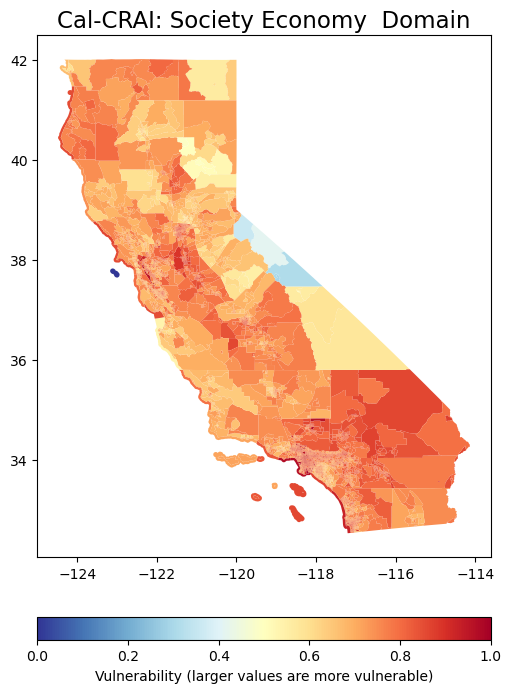

In [22]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


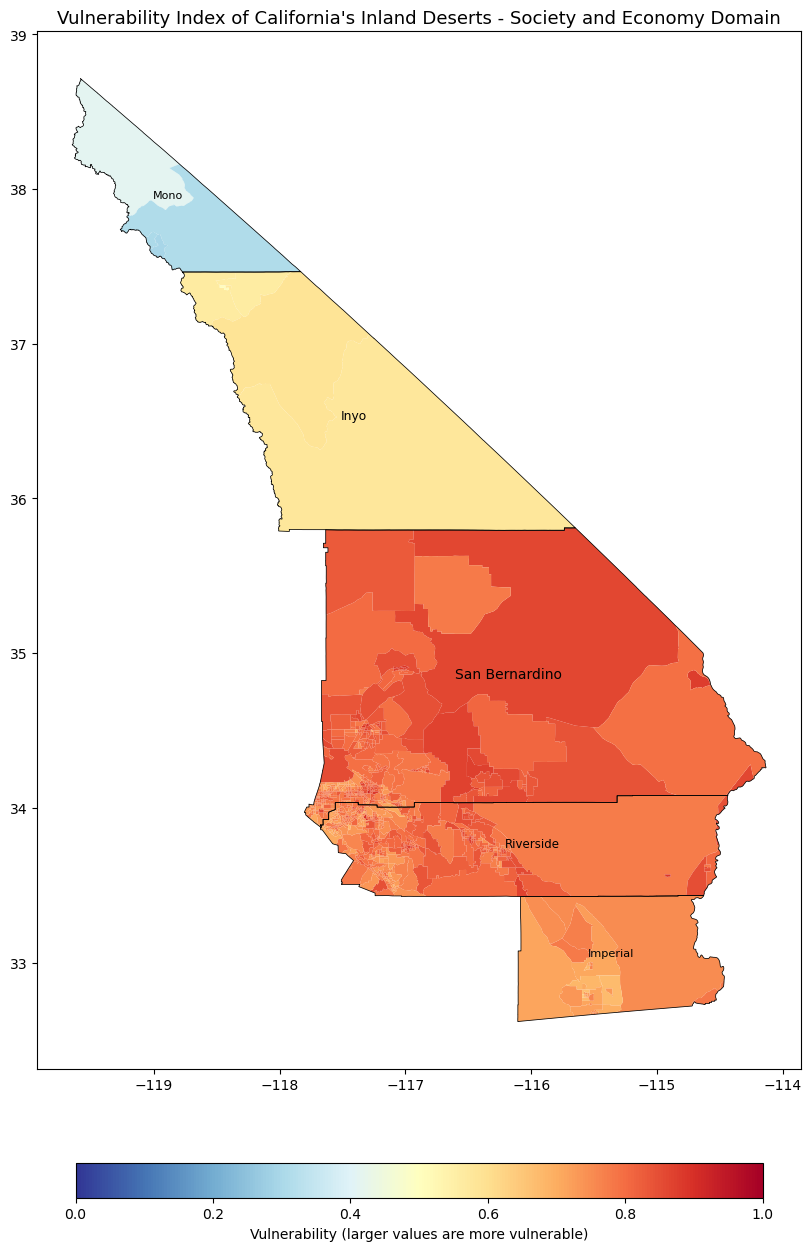

In [23]:
plot_region_domain(min_max_standardized_society_economy_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Society and Economy Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


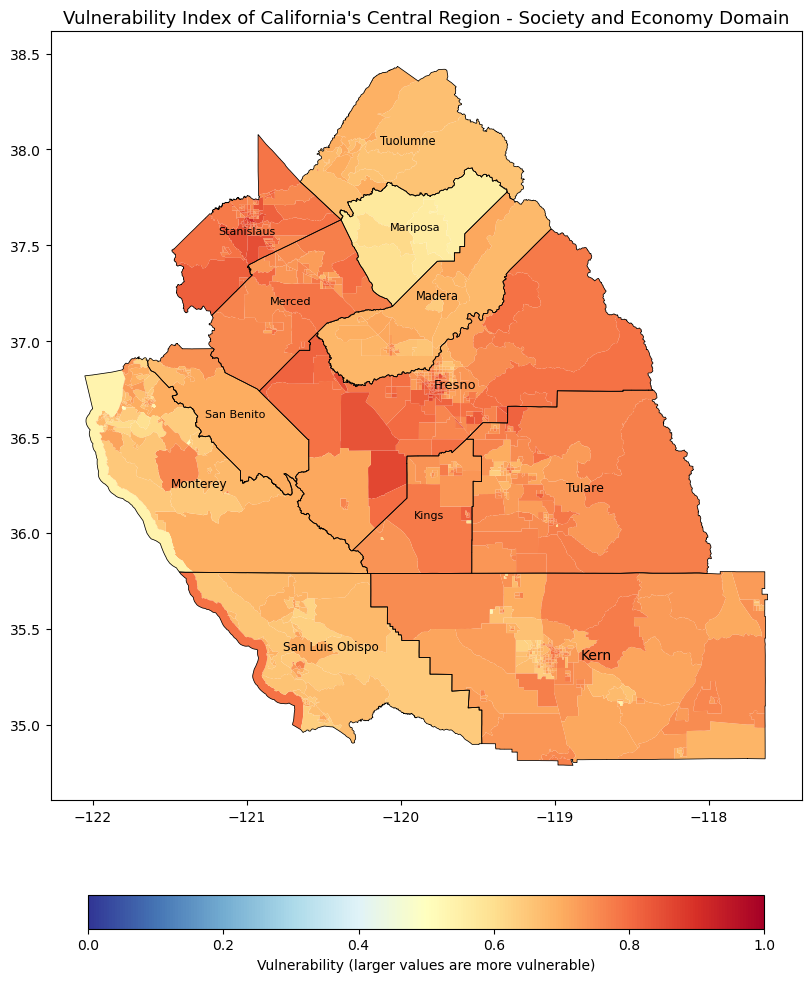

In [24]:
plot_region_domain(min_max_standardized_society_economy_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Society and Economy Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


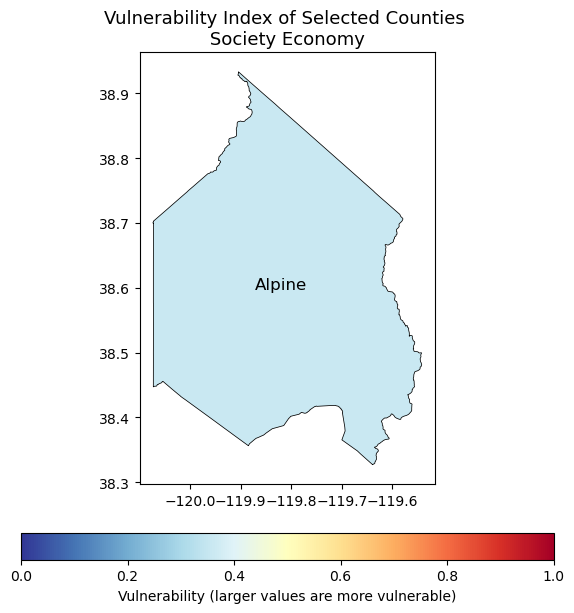

In [25]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_society_economy_domain, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


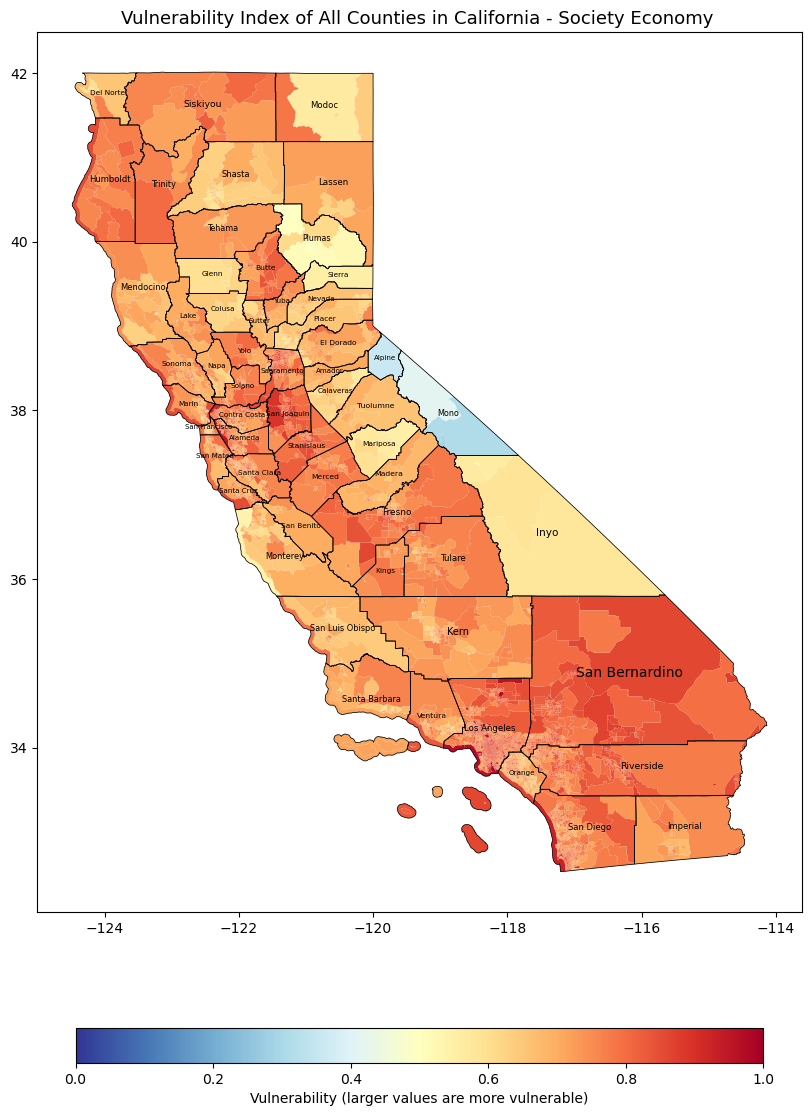

In [26]:
plot_region_domain(min_max_standardized_society_economy_domain, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [38]:
# set-up file for export
domain_filename = '{}domain_index_calculation.csv'.format(domain_prefix)
gdf.to_csv(domain_filename, index=False)

In [39]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

society_economy_domain_averaged_indicators.csv uploaded to AWS
society_economy_domain_index_calculation.csv uploaded to AWS
